<a href="https://colab.research.google.com/github/ShaliniR8/lahman-mlb/blob/main/DScolab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
from sklearn import preprocessing
from sklearn import compose
from sklearn import decomposition
from sklearn import model_selection
from sklearn.utils import compute_class_weight
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics

In [ ]:
#@title Load Dataset

%%capture
# ---- filtered (only from 1910) 
# !wget https://github.com/ShaliniR8/lahman-mlb/raw/main/baseballdatabase.zip
# !unzip /content/baseballdatabase.zip -d "/content/"


#---- full
!wget https://github.com/ShaliniR8/lahman-mlb/raw/main/baseballdatabank_2022.zip
!unzip /content/baseballdatabank_2022.zip -d "/content/"

In [ ]:
path = "/content/baseballdatabank-2022.2/core/"

In [ ]:
batting = pd.read_csv(path + "Batting.csv")
# battingPost = pd.read_csv("/content/baseballdatabank/core/BattingPost.csv")
people = pd.read_csv(path + "People.csv")
teams = pd.read_csv(path + "Teams.csv")

## Cleaning

In [ ]:
bcols = batting.columns
pcols = people.columns
tcols = teams.columns
print("Shapes : ", batting.shape, people.shape, teams.shape)
print("\nBatting Columns: ", batting.columns)
print("\nPeople Columns: ", people.columns)
print("\nTeams Columns: ", teams.columns)

Shapes :  (110495, 22) (20370, 24) (2985, 48)

Batting Columns:  Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'G', 'AB', 'R', 'H',
       '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH',
       'SF', 'GIDP'],
      dtype='object')

People Columns:  Index(['playerID', 'birthYear', 'birthMonth', 'birthDay', 'birthCountry',
       'birthState', 'birthCity', 'deathYear', 'deathMonth', 'deathDay',
       'deathCountry', 'deathState', 'deathCity', 'nameFirst', 'nameLast',
       'nameGiven', 'weight', 'height', 'bats', 'throws', 'debut', 'finalGame',
       'retroID', 'bbrefID'],
      dtype='object')

Teams Columns:  Index(['yearID', 'lgID', 'teamID', 'franchID', 'divID', 'Rank', 'G', 'Ghome',
       'W', 'L', 'DivWin', 'WCWin', 'LgWin', 'WSWin', 'R', 'AB', 'H', '2B',
       '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA',
       'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP',
       'name', 'park', 'attendance', 'BP

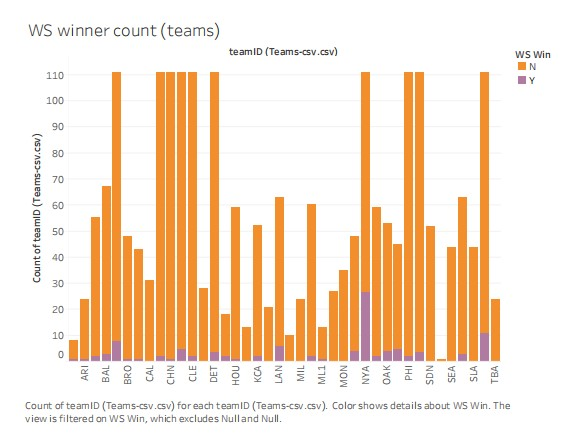

In [ ]:
# merging required columns to batting table 

df = pd.merge(
    teams[["yearID", 'teamID', 'WSWin']], batting, on=["teamID", "yearID"], how="inner"
)

df = df.drop(columns = [col for col in df.columns if '_x' in col])
rename = {}
for col in df.columns: 
  if '_y' in col: rename[col] = col[:-2]
df = df.rename(columns= rename)


df = pd.merge(
    people[["playerID", "birthYear"]].reset_index(), df.reset_index(), on=["playerID"], how="inner"
)

df = df.drop(columns = [col for col in df.columns if '_x' in col])
rename = {}
for col in df.columns: 
  if '_y' in col: rename[col] = col[:-2]
df = df.rename(columns= rename)

df = df.drop(columns=['playerID']) #will work with aggregates instead

print("Total Dataframe columns: ", df.columns)
print("length :", len(df))


Total Dataframe columns:  Index(['birthYear', 'index', 'yearID', 'teamID', 'WSWin', 'stint', 'lgID', 'G',
       'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB',
       'HBP', 'SH', 'SF', 'GIDP'],
      dtype='object')
length : 98409


In [ ]:
# remove unnecessary columns

df = df.drop(columns = ['index', 'lgID'])

In [ ]:
def missing(df): return [(col, f'{int(df[[col]].isna().sum()*100/ len(df))}%') for col in df.columns if int(df[[col]].isna().sum()*100/ len(df))>0]
print("Column with missing value percentage > 0 : \n", missing(df))

Column with missing value percentage > 0 : 
 [('WSWin', '1%'), ('CS', '12%'), ('IBB', '24%'), ('SF', '24%'), ('GIDP', '14%')]


In [ ]:
# WSWin is not numeric type, so we'll handle it separately
df[['WSWin']].describe()

,WSWin
count,96907
unique,2
top,N
freq,92891


In [ ]:
df_w = df.copy()
df_w[['WSWin']] = df_w[['WSWin']].fillna(value = 'N')

In [ ]:
df_ = df_w.fillna(value=0).copy()
print('fillna value = 0\nColumn with missing values percentage > 0 = ', missing(df_))

fillna value = 0
Column with missing values percentage > 0 =  []


In [ ]:
df_['yearID'] = df_['yearID'].apply(lambda x: int(str(x).split('-')[0]))
df_['birthYear'] = df_['birthYear'].astype(int)

In [ ]:
# batter age
df_a = df_.copy()
df_a['age'] = df_['yearID'] - df_['birthYear']
df_a = df_a.drop(columns = ['birthYear'])


In [ ]:
df_a.head(2)

,yearID,teamID,WSWin,stint,G,AB,R,H,2B,3B,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,age
0,2004,SFN,N,1,11,0,0,0,0,0,...,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,23
1,2006,CHN,N,1,45,2,0,0,0,0,...,0,0.0,0,0.0,0.0,0.0,1,0.0,0.0,25


In [ ]:
features_df=teams[['yearID', 'teamID']].copy(deep=True)

In [ ]:
import statistics

pitch_data = pd.read_csv('/content/Pitching.csv', usecols=['yearID','teamID','ERA'])
pitch_data['ERA'].replace('', np.nan, inplace=True)
pitch_data.dropna(subset=['ERA'], inplace=True)

med_era = {}

for index, row in pitch_data.iterrows():
	if row['yearID'] in med_era:
		if row['teamID'] in med_era[row['yearID']]:
			med_era[row['yearID']][row['teamID']]['eras'].append(float(row['ERA']))
		else:
			med_era[row['yearID']][row['teamID']] = {}
			med_era[row['yearID']][row['teamID']]['eras'] = [float(row['ERA'])]
	else:
		med_era[row['yearID']] = { row['teamID']:{} }
		med_era[row['yearID']][row['teamID']]['eras'] = [float(row['ERA'])]

for year in med_era:
	for team in med_era[year]:
		team_med_era = statistics.median(med_era[year][team]['eras'])
		team_index = features_df.loc[(features_df['yearID'] == year) & (features_df['teamID'] == team)].index
		features_df.loc[team_index, 'medianERA'] = team_med_era

## final total dataset

In [ ]:
df_m = df_a.copy()
rename = {}
for col in df_m.columns:
  rename[col] = 'batter_' + col
df_m = df_m.rename(columns = rename)
print(df_m.columns)

Index(['batter_yearID', 'batter_teamID', 'batter_WSWin', 'batter_stint',
       'batter_G', 'batter_AB', 'batter_R', 'batter_H', 'batter_2B',
       'batter_3B', 'batter_HR', 'batter_RBI', 'batter_SB', 'batter_CS',
       'batter_BB', 'batter_SO', 'batter_IBB', 'batter_HBP', 'batter_SH',
       'batter_SF', 'batter_GIDP', 'batter_age'],
      dtype='object')


In [ ]:
# lot of skewed data is present therefore considering median
# do more eda to explore distribution of all the features

df_f = df_m.groupby(['batter_teamID', 'batter_yearID', 'batter_WSWin']).median().reset_index()
df_f.head()

,batter_teamID,batter_yearID,batter_WSWin,batter_stint,batter_G,batter_AB,batter_R,batter_H,batter_2B,batter_3B,...,batter_SB,batter_CS,batter_BB,batter_SO,batter_IBB,batter_HBP,batter_SH,batter_SF,batter_GIDP,batter_age
0,ANA,1997,N,1.0,33.0,6.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,29.0
1,ANA,1998,N,1.0,39.0,14.0,1.0,2.0,1.0,0.0,...,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,31.0
2,ANA,1999,N,1.0,30.0,20.0,3.0,3.0,1.0,0.0,...,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,30.0
3,ANA,2000,N,1.0,24.0,3.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0
4,ANA,2001,N,1.0,42.0,16.0,1.0,2.5,0.0,0.0,...,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,28.0


## Preprocessing for all

In [ ]:
colsX = list(df_f.columns)
colsX.remove('batter_WSWin')
colsY = 'batter_WSWin'

In [ ]:
# encoding 
ordinalEncoder  = preprocessing.OrdinalEncoder() # --> for teamID
ohEncoder = preprocessing.OneHotEncoder() # --> for year

columnTransf = compose.ColumnTransformer([
    # ('ordinal', ordinalEncoder, ["batter_teamID"]),
    ('onehot', ohEncoder, ["batter_yearID", "batter_teamID"])
])

labelEncoder = preprocessing.LabelEncoder() 

X = columnTransf.fit_transform(df_f[colsX])
y = labelEncoder.fit_transform(df_f[colsY])

In [ ]:
print("Shapes of feature data and target : ", X.shape, y.shape) # --> how do i get feature names?

Shapes of feature data and target :  (2458, 166) (2458,)


In [ ]:
# dimensionality reduction 

tsvd = decomposition.TruncatedSVD(n_components = int(X.shape[1]*0.01)) # --> arbitrary n_components, needs work on
X_tsvd = tsvd.fit_transform(X)
print(X_tsvd.shape)

(2458, 1)


same scores for all number of n_components. Why??

## Train test split for all

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=0)

## Model for all

In [ ]:
clf = ensemble.AdaBoostClassifier(n_estimators=100, random_state=0)
cv_results = model_selection.cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')

clf_lr = linear_model.LogisticRegression(class_weight='balanced')
cv_results_lr = model_selection.cross_val_score(clf_lr, X_train, y_train, cv=5, scoring='f1')

In [ ]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (cv_results.mean(), cv_results.std())) # adaboost, cv

0.00 accuracy with a standard deviation of 0.00


In [ ]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (cv_results_lr.mean(), cv_results_lr.std())) #lr, cv

0.08 accuracy with a standard deviation of 0.03


In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred, target_names=['N', 'Y'], zero_division=0)) #adaboost, test

              precision    recall  f1-score   support

           N       0.96      0.99      0.98       472
           Y       0.00      0.00      0.00        20

    accuracy                           0.95       492
   macro avg       0.48      0.50      0.49       492
weighted avg       0.92      0.95      0.94       492



In [ ]:
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)
print(metrics.classification_report(y_test, y_pred_lr, target_names=['N', 'Y'], zero_division=0)) #lr, test

              precision    recall  f1-score   support

           N       0.96      0.74      0.83       472
           Y       0.04      0.25      0.07        20

    accuracy                           0.72       492
   macro avg       0.50      0.49      0.45       492
weighted avg       0.92      0.72      0.80       492



###Observation : Changing from ordinal to one hot encoder was the only preprocessing component that had an effect on the results. Why?

ordinal -> not binary
Should we try to use MinMax scaler on the rest of the features?

## Same thing but for batter_age only 

In [ ]:
colsX_age = ['batter_teamID', 'batter_age']

columnTransf = compose.ColumnTransformer([('onehot', ohEncoder, ['batter_teamID'])])
X_age = columnTransf.fit_transform(df_f)
X_train_age, X_test_age, y_train_age, y_test_age = model_selection.train_test_split(X_age, y, test_size=0.20, random_state=0)

In [ ]:
clf_age = ensemble.AdaBoostClassifier(n_estimators=100, random_state=0)
cv_results_age = model_selection.cross_val_score(clf_age, X_train_age, y_train_age, cv=5, scoring='f1')

In [ ]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (cv_results_age.mean(), cv_results_age.std())) #ada, cv

0.00 accuracy with a standard deviation of 0.00


In [ ]:
clf_age.fit(X_train_age, y_train_age)
y_pred_age = clf_age.predict(X_test_age)
print(metrics.classification_report(y_test_age, y_pred_age, target_names=['N', 'Y'], zero_division=0)) # ada, test

              precision    recall  f1-score   support

           N       0.96      1.00      0.98       472
           Y       0.00      0.00      0.00        20

    accuracy                           0.96       492
   macro avg       0.48      0.50      0.49       492
weighted avg       0.92      0.96      0.94       492



In [ ]:
clf_age_lr = linear_model.LogisticRegression(class_weight='balanced', random_state=0)
cv_results_age_lr = model_selection.cross_val_score(clf_age_lr, X_train_age, y_train_age, cv=5, scoring='f1')
print("%0.2f accuracy with a standard deviation of %0.2f" % (cv_results_age_lr.mean(), cv_results_age_lr.std())) #lr, cv

0.14 accuracy with a standard deviation of 0.02


In [ ]:
clf_age_lr.fit(X_train_age, y_train_age)
y_pred_age_lr = clf_age_lr.predict(X_test_age)
print(metrics.classification_report(y_test_age, y_pred_age_lr, target_names=['N', 'Y'], zero_division=0)) #lr, test

              precision    recall  f1-score   support

           N       0.98      0.72      0.83       472
           Y       0.08      0.60      0.15        20

    accuracy                           0.72       492
   macro avg       0.53      0.66      0.49       492
weighted avg       0.94      0.72      0.80       492

